# Library

In [ ]:
# Data handling
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Utilities
from pandas.api.types import CategoricalDtype
import holidays
import warnings
warnings.filterwarnings("ignore")
from itertools import product
from tabulate import tabulate
from tqdm.notebook import tqdm

# Machine Learning - Traditional
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Machine Learning - Deep Learning (PyTorch)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


# Data

In [2]:
df = pd.read_csv(r"C:\Documents\DAIICT\SEM 2\forcasting\project\traffic.csv",index_col=[0],parse_dates=[0])
df.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [3]:
df.shape

(48120, 3)

# Preprocessing

JUNCTION 1:

In [4]:
df1 = df[df['Junction'] == 1]            
df1 = df1.drop(columns=['ID', 'Junction'])
df1.head()

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9


In [5]:
df1.shape

(14592, 1)

In [6]:
if(df1.isnull().sum().sum()==0):
    print('No missing values.')
else:
    df1.fillna(method='ffill',inplace=True)

No missing values.


## Feature engineering

In [7]:
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday',
                                        'Thursday', 'Friday', 'Saturday', 'Sunday'],
                            ordered=True)

us_holidays = holidays.US(years=[2015, 2016, 2017])

def create_features(df1, label=None):
    df1 = df1.copy()
    df1['date'] = df1.index
    df1['hour'] = df1['date'].dt.hour
    df1['weekday'] = df1['date'].dt.day_name()
    df1['weekday'] = df1['weekday'].astype(cat_type)
    df1['month'] = df1['date'].dt.month
    df1['year'] = df1['date'].dt.year
    df1['date_offset'] = (df1.date.dt.month * 100 + df1.date.dt.day - 320) % 1300

    X = df1[['hour', 'weekday', 'month', 'year']]
    if label:
        y = df1[label]
        return X, y
    return X

X, y = create_features(df1, label='Vehicles')
features_and_target = pd.concat([X, y], axis=1)

In [8]:
df_daily = df1.resample('D').mean()

## Data Visualization

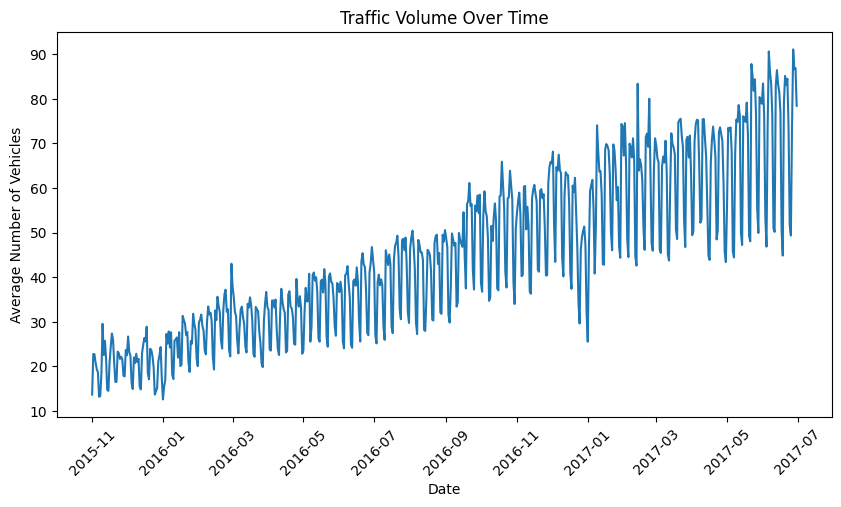

In [9]:
plt.figure(figsize=(10, 5))
df_daily = df1.resample('D').mean()
plt.plot(df_daily.index, df_daily['Vehicles'])
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Average Number of Vehicles')
plt.show()

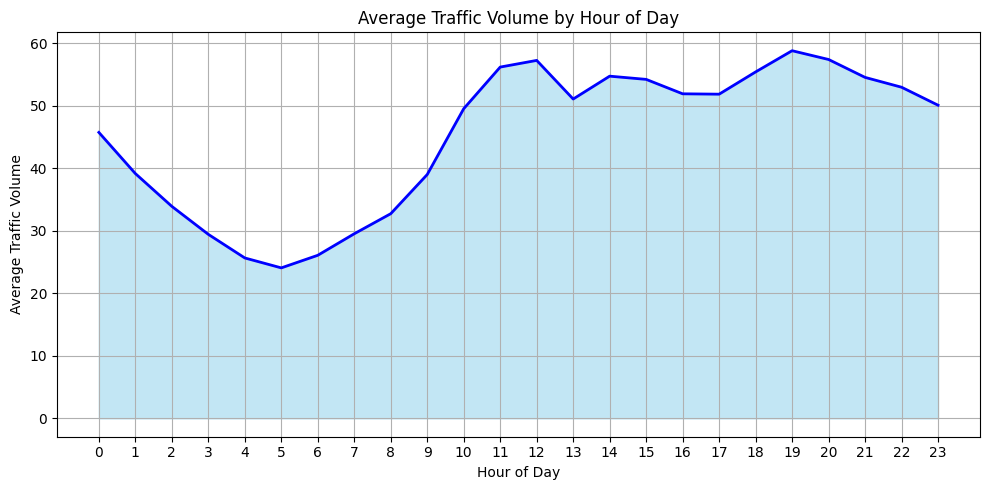

In [10]:
plt.figure(figsize=(10, 5))
avg_traffic_by_hour = features_and_target.groupby('hour')['Vehicles'].mean()

plt.fill_between(avg_traffic_by_hour.index, avg_traffic_by_hour.values, color='skyblue', alpha=0.5)
plt.plot(avg_traffic_by_hour.index, avg_traffic_by_hour.values, color='blue', linewidth=2)

plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


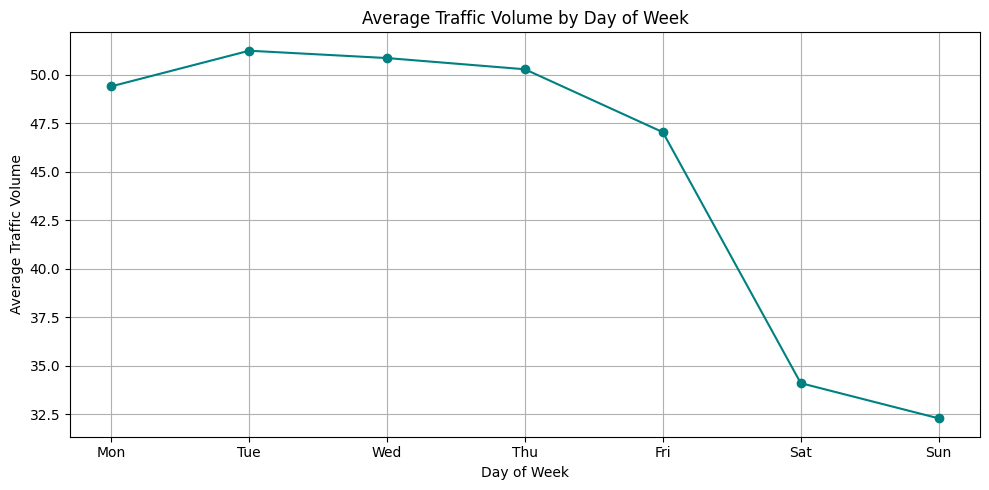

In [11]:
plt.figure(figsize=(10, 5))
average_traffic_by_day = features_and_target.groupby('weekday')['Vehicles'].mean()
plt.plot(average_traffic_by_day.index, average_traffic_by_day.values, marker='o', linestyle='-', color='teal')

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(ticks=range(7), labels=days)

plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Traffic Volume')
plt.grid(True)
plt.tight_layout()
plt.show()


## Time Series Decomposition

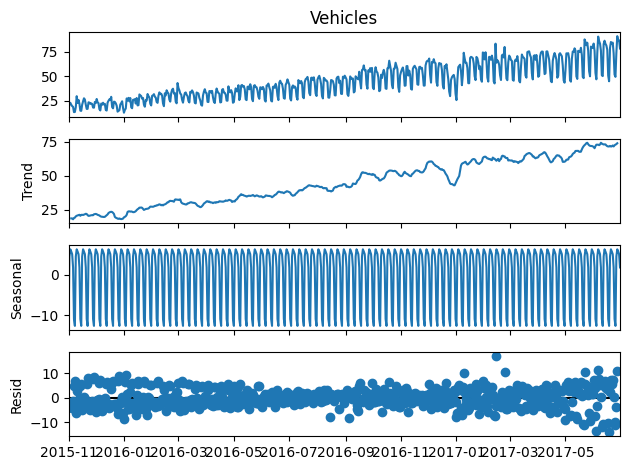

In [12]:
result = seasonal_decompose(df_daily['Vehicles'], model='additive', period=7)
result.plot()
plt.tight_layout()
plt.show()

In [13]:
train = df_daily[:'2016-12-31']
test = df_daily['2017-01-01':]


## Check stationary

In [14]:
result = adfuller(df_daily['Vehicles'])
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                             |
|---------------|-----------------------------------|
| ADF Statistic | -0.3413815102045648               |
| P-value       | 0.9194355530673952                |
| Conclusion    | The time series is not stationary |


#### The time series is not stationary. Hence differencing :

In [15]:
train_diff = train.diff().dropna()

In [16]:
result = adfuller(train_diff['Vehicles'])
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                         |
|---------------|-------------------------------|
| ADF Statistic | -5.449863589921822            |
| P-value       | 2.659250437078119e-06         |
| Conclusion    | The time series is stationary |


# ACF-PACF

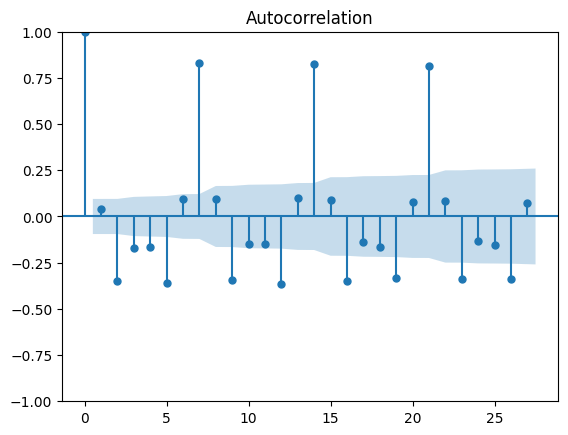

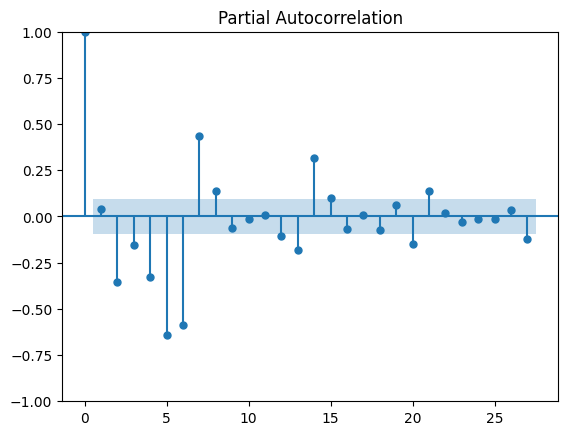

In [17]:
fig1 = plot_acf(train_diff['Vehicles'])
fig2 = plot_pacf(train_diff['Vehicles'])
plt.show()


### Not a random Walk. Also as ACF and PACF does not deplet after few lags , not a MA or AR process : Hence applying ARMA Directly

In [18]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train = train['Vehicles']
test = test['Vehicles']

# ARMA


Best ARMA order: (4, 0, 4) with AIC: 2339.8160562655557


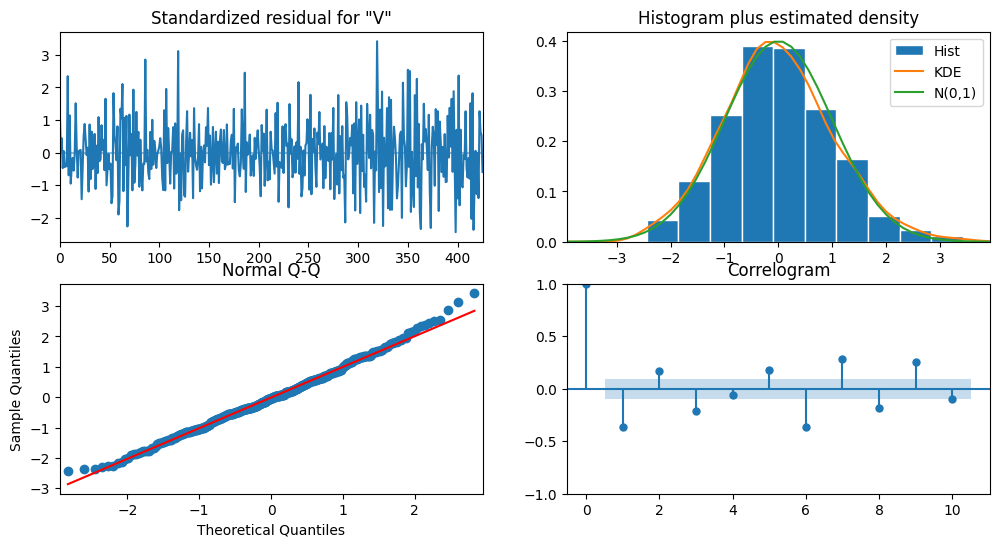

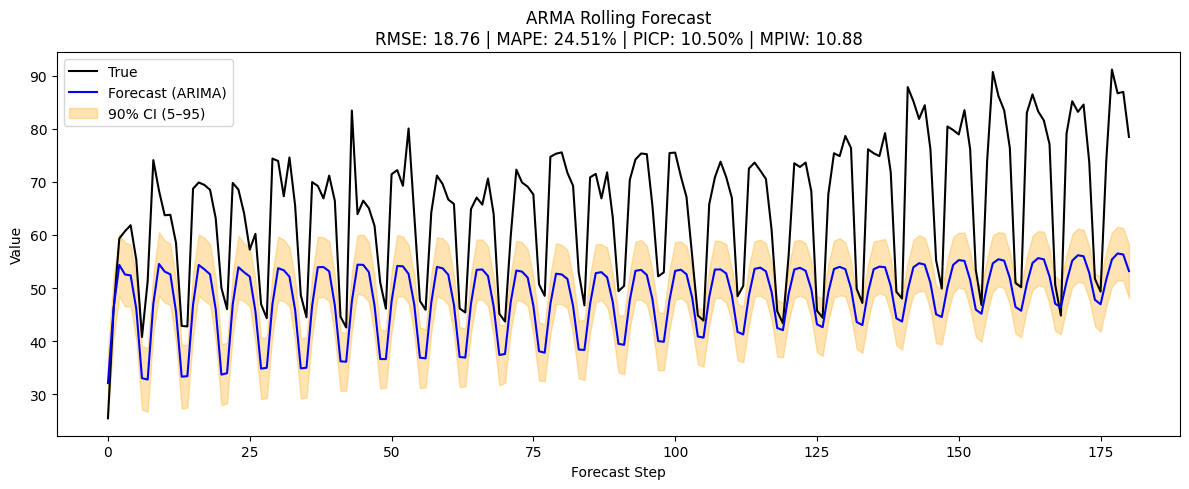

In [19]:
train_diff = train.diff().dropna()

p_values = range(0, 5)
q_values = range(0, 5)
d = 0 

''' AIC '''
best_aic = float('inf')
best_order = None
best_model = None



for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(train_diff, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            #
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
                best_model = model_fit
        except:
            continue

print(f"\nBest ARMA order: {best_order} with AIC: {best_aic}")


fig = best_model.plot_diagnostics(figsize=(12, 6))
plt.show()

rolling_forecasts = []
conf_ints = []
history = list(train_diff)

last_obs = train.iloc[-1]   

for _ in range(len(test)):
    model = ARIMA(history, order=(4, 0, 4))  
    model_fit = model.fit()
    forecast_result = model_fit.get_forecast(steps=1)

    diff_forecast = forecast_result.predicted_mean[0]
    ci = forecast_result.conf_int(alpha=0.1)
    diff_lower = ci[0][0]
    diff_upper = ci[0][1]

    actual_forecast = last_obs + diff_forecast
    lower_bound = last_obs + diff_lower
    upper_bound = last_obs + diff_upper

    rolling_forecasts.append(actual_forecast)
    conf_ints.append((lower_bound, upper_bound))

    history.append(diff_forecast)
    last_obs = actual_forecast 


forecast_values = rolling_forecasts
lower_bounds = np.array([ci[0] for ci in conf_ints])
upper_bounds = np.array([ci[1] for ci in conf_ints])

within_interval = (test >= lower_bounds) & (test <= upper_bounds)
picp = np.mean(within_interval)
mpiw = mpiw = np.mean(np.array(upper_bounds) - np.array(lower_bounds))
mape = np.mean(np.abs((test - forecast_values) / test)) * 100


rmse = np.sqrt(mean_squared_error(test, forecast_values))


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(test, label='True', color='black')
plt.plot(forecast_values, label='Forecast (ARIMA)', color='blue')
plt.fill_between(range(len(test)), lower_bounds, upper_bounds, color='orange', alpha=0.3, label='90% CI (5–95)')
plt.title(f"ARMA Rolling Forecast\nRMSE: {rmse:.2f} | MAPE: {mape:.2f}% | PICP: {picp*100:.2f}% | MPIW: {mpiw:.2f}")
plt.xlabel("Forecast Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# ARIMA 


Best ARIMA order: (4, 1, 4) with AIC: 152.45


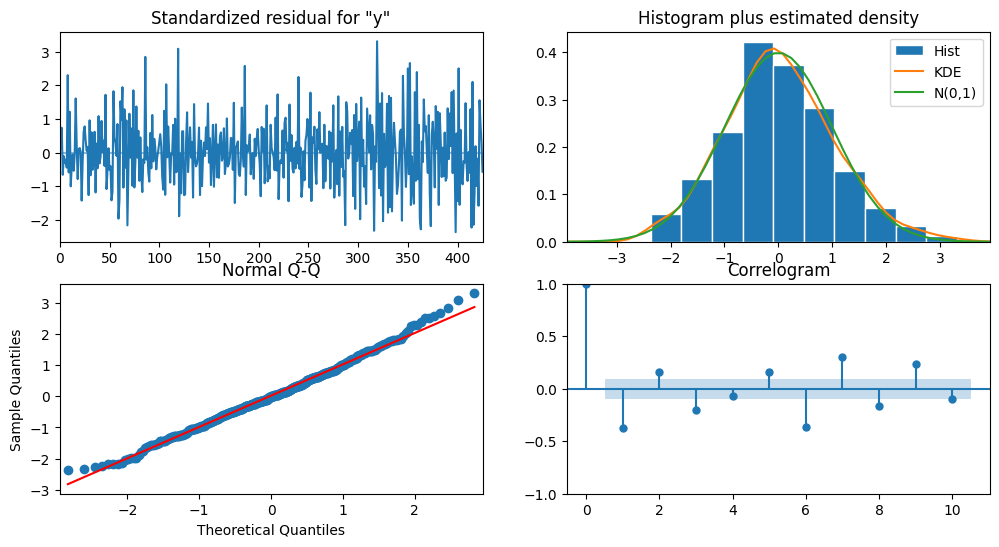

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")  

# ---- Find Best ARIMA(p,d,q) using AIC ----
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)

best_aic = float('inf')
best_order = None
best_model = None
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y_scaled = scaler.fit_transform(train.values.reshape(-1, 1)).ravel()
for p in p_values:
    for q in q_values:
        for d in d_values:
            try:
                model = ARIMA(y_scaled, order=(p,d, q), enforce_stationarity=True, enforce_invertibility=True)
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"\nBest ARIMA order: {best_order} with AIC: {best_aic:.2f}")

best_model.plot_diagnostics(figsize=(12,6))
plt.show()

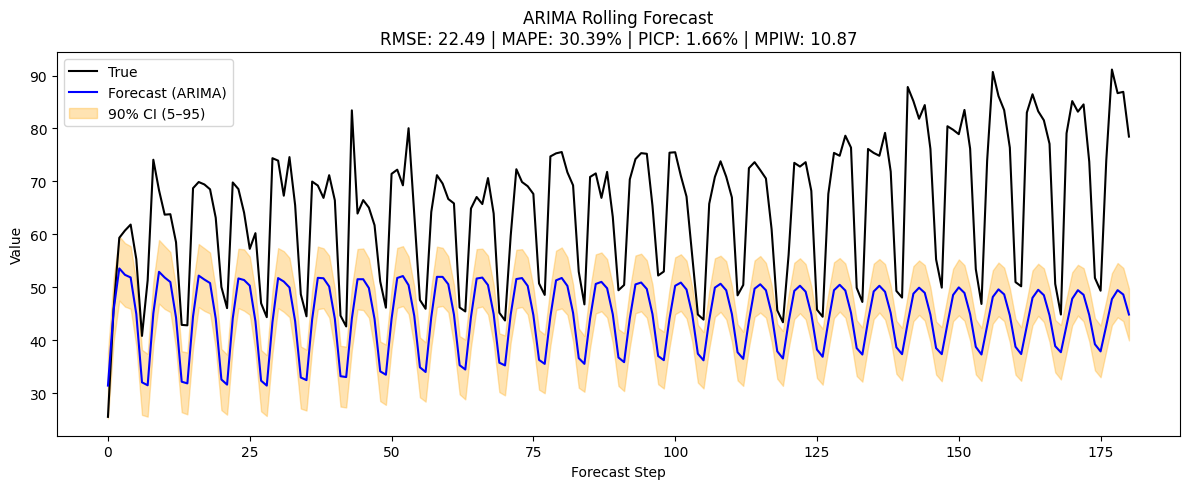

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")  


order = (4, 1, 4)

model = ARIMA(train, order=order)
model_fit = model.fit()


rolling_forecasts = []
conf_ints = []
history = list(train)

for _ in range(len(test)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    forecast_result = model_fit.get_forecast(steps=1)

    forecast_value = forecast_result.predicted_mean[0]
    ci = forecast_result.conf_int(alpha=0.1)
    lower_bound = ci[0][0]
    upper_bound = ci[0][1]

    rolling_forecasts.append(forecast_value)
    conf_ints.append((lower_bound, upper_bound))

    history.append(forecast_value)


lower_bounds = np.array([ci[0] for ci in conf_ints])
upper_bounds = np.array([ci[1] for ci in conf_ints])


within_interval = (test >= lower_bounds) & (test <= upper_bounds)
picp = np.mean(within_interval)
mpiw = np.mean(upper_bounds - lower_bounds)
rmse = np.sqrt(mean_squared_error(test, rolling_forecasts))
mape = np.mean(np.abs((test.values - rolling_forecasts) / test.values)) * 100

plt.figure(figsize=(12, 5))
plt.plot(test.values, label='True', color='black')
plt.plot(rolling_forecasts, label='Forecast (ARIMA)', color='blue')
plt.fill_between(range(len(test)), lower_bounds, upper_bounds, color='orange', alpha=0.3, label='90% CI (5–95)')
plt.title(f"ARIMA Rolling Forecast\nRMSE: {rmse:.2f} | MAPE: {mape:.2f}% | PICP: {picp*100:.2f}% | MPIW: {mpiw:.2f}")
plt.xlabel("Forecast Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# SARIMA

Best SARIMA order: (1, 1, 2) x (0, 1, 1)7 with AIC: 2013.0329564965791


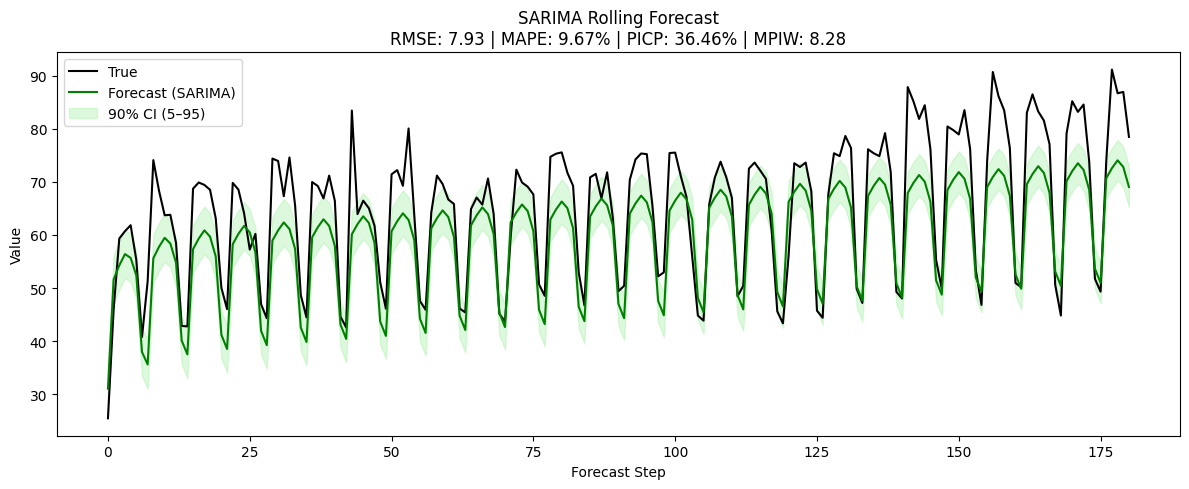

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 7  

best_aic = float("inf")
best_order = None
best_seasonal = None

for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(train,
                            order=order,
                            seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal = seasonal_order
        except:
            continue

print(f"Best SARIMA order: {best_order} x {best_seasonal}{s} with AIC: {best_aic}")


rolling_forecasts = []
conf_ints = []
history = list(train)

seasonal_order_full = (best_seasonal[0], best_seasonal[1], best_seasonal[2], s)

for _ in range(len(test)):
    model = SARIMAX(history,
                    order=best_order,
                    seasonal_order=seasonal_order_full,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    model_fit = model.fit(disp=False)
    forecast_result = model_fit.get_forecast(steps=1)
    
    forecast_value = forecast_result.predicted_mean[0]
    ci = forecast_result.conf_int(alpha=0.1)  # 90% CI
    lower_bound = ci[0][0]
    upper_bound = ci[0][1]
    
    rolling_forecasts.append(forecast_value)
    conf_ints.append((lower_bound, upper_bound))
    
    history.append(forecast_value)

lower_bounds = np.array([ci[0] for ci in conf_ints])
upper_bounds = np.array([ci[1] for ci in conf_ints])

within_interval = (test >= lower_bounds) & (test <= upper_bounds)
picp = np.mean(within_interval)
mpiw = np.mean(upper_bounds - lower_bounds)
rmse = np.sqrt(mean_squared_error(test, rolling_forecasts))
mape = np.mean(np.abs((test.values - rolling_forecasts) / test.values)) * 100


plt.figure(figsize=(12, 5))
plt.plot(test.values, label='True', color='black')
plt.plot(rolling_forecasts, label='Forecast (SARIMA)', color='green')
plt.fill_between(range(len(test)), lower_bounds, upper_bounds, color='lightgreen', alpha=0.3, label='90% CI (5–95)')
plt.title(f"SARIMA Rolling Forecast\nRMSE: {rmse:.2f} | MAPE: {mape:.2f}% | PICP: {picp*100:.2f}% | MPIW: {mpiw:.2f}")
plt.xlabel("Forecast Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# Deep Learning Model

In [ ]:
df1.index = pd.to_datetime(df1.index)
data = df1['Vehicles'].values.reshape(-1, 1)

'''Normalize the data'''
scaler = MinMaxScaler()
data = scaler.fit_transform(data)


def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 24
X, y = create_sequences(data, SEQ_LEN)

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i:i+1]
            loss = torch.max((q - 1) * errors, q * errors)
            losses.append(loss)
        return torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))

In [ ]:
def train_and_evaluate_quantile_model(model, dataloader, X_tensor, y_tensor, val_dataloader, scaler, quantiles, epochs=20, lr=0.001, rolling_steps=50):
    criterion = QuantileLoss(quantiles)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []


    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for xb, yb in dataloader:
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(dataloader))

 
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_dataloader:
                preds = model(xb)
                loss = criterion(preds, yb)
                total_val_loss += loss.item()
        val_losses.append(total_val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    model.eval()
    q05_preds = []
    q50_preds = []
    q90_preds = []
    true_vals = []

    X_roll = X_tensor.clone()
    y_roll = y_tensor.clone()

    with torch.no_grad():
        for i in range(rolling_steps):
            input_x = X_roll[i:i+1]  
            target_y = y_roll[i].numpy()

            pred = model(input_x).numpy()
            q05 = scaler.inverse_transform(pred[:, 0:1])[0, 0]
            q50 = scaler.inverse_transform(pred[:, 1:2])[0, 0]
            q90 = scaler.inverse_transform(pred[:, 2:3])[0, 0]
            true_y = scaler.inverse_transform(target_y.reshape(-1, 1))[0, 0]

            q05_preds.append(q05)
            q50_preds.append(q50)
            q90_preds.append(q90)
            true_vals.append(true_y)

    # ---- Metrics ----
    rmse = np.sqrt(mean_squared_error(true_vals, q50_preds))
    mape = mean_absolute_percentage_error(true_vals, q50_preds)
    picp = np.mean((np.array(true_vals) >= np.array(q05_preds)) & (np.array(true_vals) <= np.array(q90_preds)))
    mpiw = np.mean(np.array(q90_preds) - np.array(q05_preds))

    print(f"\n--- Rolling Forecast Evaluation ---")
    print(f"RMSE (Median): {rmse:.2f}")
    print(f"MAPE (Median): {mape * 100:.2f}%")
    print(f"PICP (Coverage): {picp * 100:.2f}%")
    print(f"MPIW (Interval Width): {mpiw:.2f}")

    plt.figure(figsize=(12, 5))

   
    plt.subplot(1, 2, 1)
    plt.plot(true_vals, label='True', color='black')
    plt.plot(q50_preds, label='Predicted Median (Q50)', color='blue')
    plt.fill_between(range(rolling_steps), q05_preds, q90_preds, color='orange', alpha=0.3, label='Q05–Q90 Interval')
    plt.legend()
    plt.title(f"Rolling Quantile Forecast\nRMSE: {rmse:.2f} | MAPE: {mape*100:.2f}% | PICP: {picp*100:.2f}% | MPIW: {mpiw:.2f}")
    plt.xlabel("Time Steps")
    plt.ylabel("Vehicle Count")

   
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
    plt.plot(range(epochs), val_losses, label='Validation Loss', color='orange')
    plt.legend()
    plt.title("Training and Validation Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()

    return {
        'q05': np.array(q05_preds),
        'q50': np.array(q50_preds),
        'q90': np.array(q90_preds),
        'true': np.array(true_vals),
        'rmse': rmse,
        'mape': mape,
        'picp': picp,
        'mpiw': mpiw
    }


### RNN :

In [ ]:
class RNNQuantile(nn.Module):
    def __init__(self, input_size, hidden_size,quantiles=[0.05, 0.5, 0.95], num_layers=2, dropout = 0.2):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                           dropout=dropout if num_layers > 1 else 0.0,
                           batch_first=True)
        self.fc = nn.Linear(hidden_size, len(quantiles))

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out)

Epoch 1, Train Loss: 0.0581, Val Loss: 0.0324
Epoch 2, Train Loss: 0.0310, Val Loss: 0.0267
Epoch 3, Train Loss: 0.0274, Val Loss: 0.0246
Epoch 4, Train Loss: 0.0266, Val Loss: 0.0246
Epoch 5, Train Loss: 0.0262, Val Loss: 0.0245
Epoch 6, Train Loss: 0.0259, Val Loss: 0.0247
Epoch 7, Train Loss: 0.0255, Val Loss: 0.0241
Epoch 8, Train Loss: 0.0252, Val Loss: 0.0233
Epoch 9, Train Loss: 0.0250, Val Loss: 0.0231
Epoch 10, Train Loss: 0.0237, Val Loss: 0.0221
Epoch 11, Train Loss: 0.0229, Val Loss: 0.0224
Epoch 12, Train Loss: 0.0231, Val Loss: 0.0225
Epoch 13, Train Loss: 0.0229, Val Loss: 0.0220
Epoch 14, Train Loss: 0.0224, Val Loss: 0.0205
Epoch 15, Train Loss: 0.0221, Val Loss: 0.0206
Epoch 16, Train Loss: 0.0223, Val Loss: 0.0207
Epoch 17, Train Loss: 0.0220, Val Loss: 0.0202
Epoch 18, Train Loss: 0.0218, Val Loss: 0.0203
Epoch 19, Train Loss: 0.0218, Val Loss: 0.0203
Epoch 20, Train Loss: 0.0219, Val Loss: 0.0205

--- Rolling Forecast Evaluation ---
RMSE (Median): 3.92
MAPE (Median

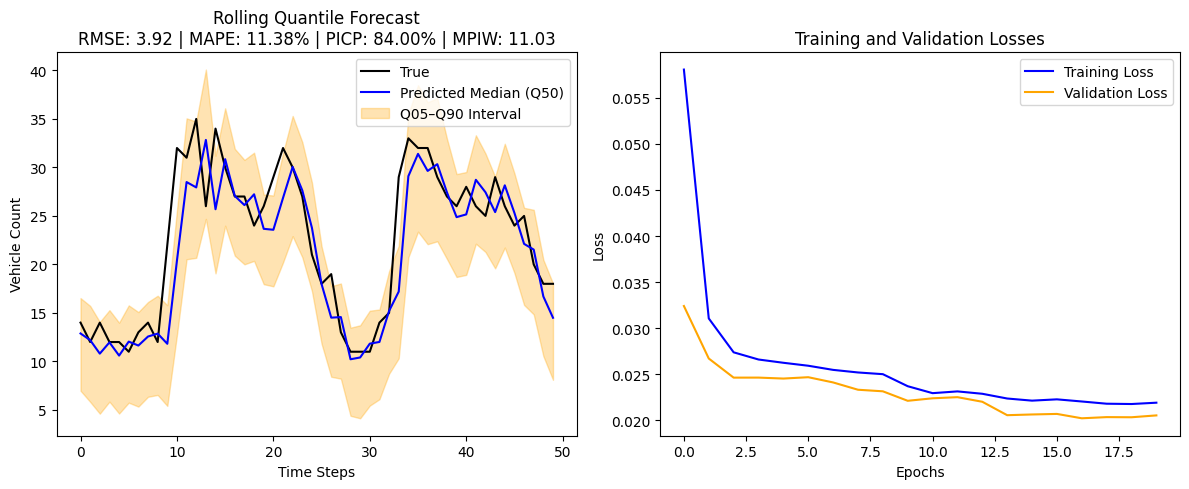

In [ ]:
quantiles = [0.05, 0.5, 0.9]
rnn = RNNQuantile(input_size=1, hidden_size=64, quantiles=quantiles)

metrics = train_and_evaluate_quantile_model(
    model=rnn,
    dataloader=train_dataloader,  
    X_tensor=X_tensor,
    y_tensor=y_tensor,
    val_dataloader=val_dataloader,  
    scaler=scaler,
    quantiles=quantiles,
    epochs=20,
    lr=0.001
)

### LSTM :

In [ ]:
class LSTMQuantile(nn.Module):
    def __init__(self, input_size, hidden_size,quantiles=[0.05, 0.5, 0.95]):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, len(quantiles))

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        return self.fc(out)

Epoch 1, Train Loss: 0.0928, Val Loss: 0.0568
Epoch 2, Train Loss: 0.0482, Val Loss: 0.0375
Epoch 3, Train Loss: 0.0370, Val Loss: 0.0316
Epoch 4, Train Loss: 0.0323, Val Loss: 0.0260
Epoch 5, Train Loss: 0.0296, Val Loss: 0.0233
Epoch 6, Train Loss: 0.0276, Val Loss: 0.0242
Epoch 7, Train Loss: 0.0263, Val Loss: 0.0224
Epoch 8, Train Loss: 0.0255, Val Loss: 0.0223
Epoch 9, Train Loss: 0.0247, Val Loss: 0.0216
Epoch 10, Train Loss: 0.0244, Val Loss: 0.0221
Epoch 11, Train Loss: 0.0243, Val Loss: 0.0232
Epoch 12, Train Loss: 0.0235, Val Loss: 0.0204
Epoch 13, Train Loss: 0.0236, Val Loss: 0.0203
Epoch 14, Train Loss: 0.0232, Val Loss: 0.0211
Epoch 15, Train Loss: 0.0228, Val Loss: 0.0203
Epoch 16, Train Loss: 0.0231, Val Loss: 0.0237
Epoch 17, Train Loss: 0.0227, Val Loss: 0.0202
Epoch 18, Train Loss: 0.0227, Val Loss: 0.0200
Epoch 19, Train Loss: 0.0223, Val Loss: 0.0197
Epoch 20, Train Loss: 0.0221, Val Loss: 0.0197

--- Rolling Forecast Evaluation ---
RMSE (Median): 3.58
MAPE (Median

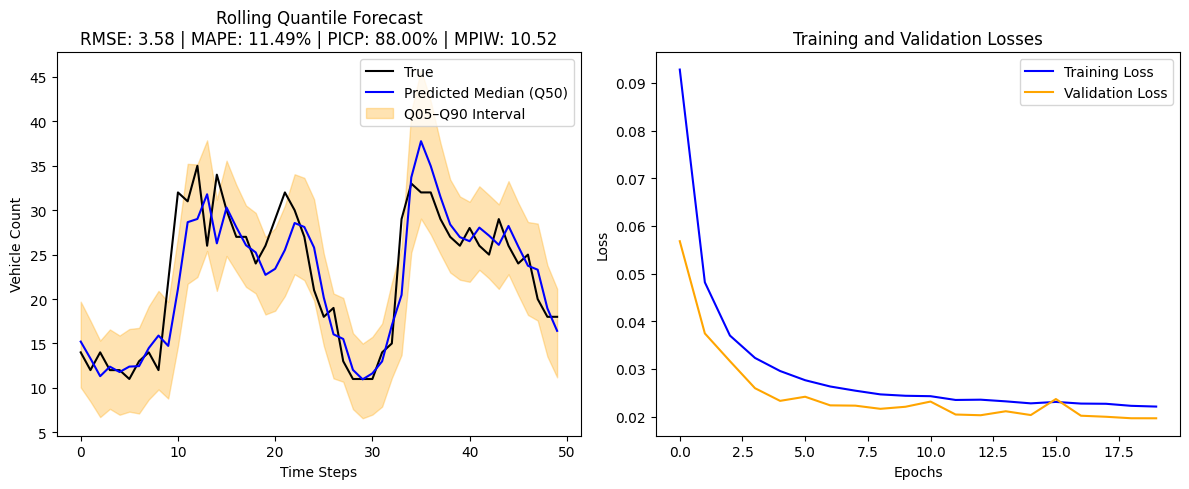

In [ ]:
lstm = LSTMQuantile(input_size=1, hidden_size=64)

metrics = train_and_evaluate_quantile_model(
    model=lstm,
    dataloader=train_dataloader,  
    X_tensor=X_tensor,
    y_tensor=y_tensor,
    val_dataloader=val_dataloader,  
    scaler=scaler,
    quantiles=quantiles,
    epochs=20,
    lr=0.001
)

### GRU :

In [ ]:
class GRUQuantile(nn.Module):
    def __init__(self, input_size, hidden_size, quantiles=[0.05, 0.5, 0.95]):
        super().__init__()
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, len(quantiles))

    def forward(self, x):
        out, _ = self.gru1(x)
        out = self.dropout1(out)
        out, _ = self.gru2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]  
        return self.fc(out)

Epoch 1, Train Loss: 0.0641, Val Loss: 0.0331
Epoch 2, Train Loss: 0.0340, Val Loss: 0.0270
Epoch 3, Train Loss: 0.0307, Val Loss: 0.0250
Epoch 4, Train Loss: 0.0281, Val Loss: 0.0235
Epoch 5, Train Loss: 0.0271, Val Loss: 0.0232
Epoch 6, Train Loss: 0.0261, Val Loss: 0.0257
Epoch 7, Train Loss: 0.0260, Val Loss: 0.0233
Epoch 8, Train Loss: 0.0254, Val Loss: 0.0225
Epoch 9, Train Loss: 0.0248, Val Loss: 0.0224
Epoch 10, Train Loss: 0.0247, Val Loss: 0.0224
Epoch 11, Train Loss: 0.0246, Val Loss: 0.0225
Epoch 12, Train Loss: 0.0244, Val Loss: 0.0219
Epoch 13, Train Loss: 0.0240, Val Loss: 0.0223
Epoch 14, Train Loss: 0.0240, Val Loss: 0.0232
Epoch 15, Train Loss: 0.0240, Val Loss: 0.0230
Epoch 16, Train Loss: 0.0238, Val Loss: 0.0224
Epoch 17, Train Loss: 0.0233, Val Loss: 0.0212
Epoch 18, Train Loss: 0.0230, Val Loss: 0.0214
Epoch 19, Train Loss: 0.0231, Val Loss: 0.0218
Epoch 20, Train Loss: 0.0227, Val Loss: 0.0204

--- Rolling Forecast Evaluation ---
RMSE (Median): 3.57
MAPE (Median

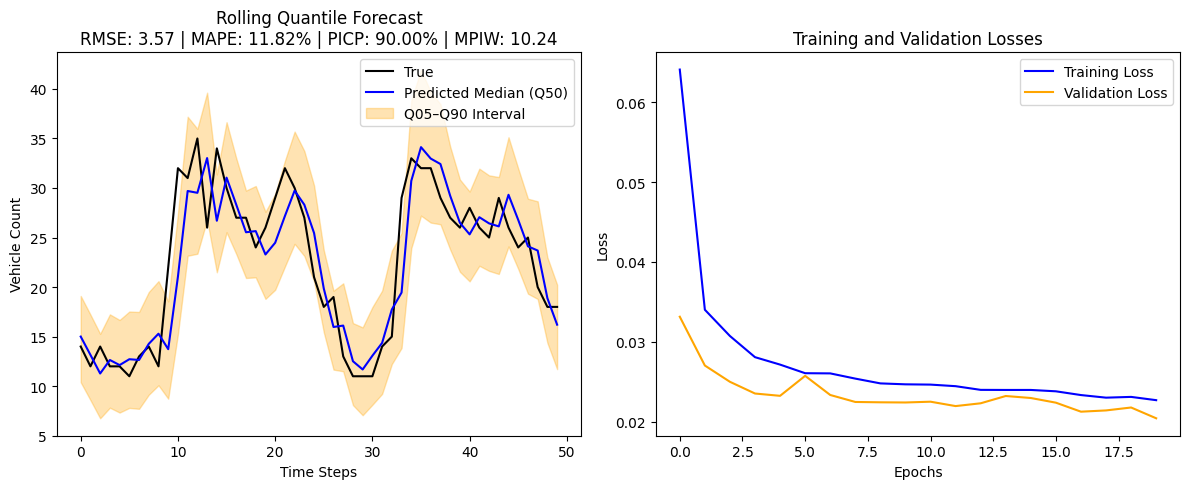

In [ ]:
gru = GRUQuantile(input_size=1, hidden_size=64)

metrics = train_and_evaluate_quantile_model(
    model=gru,
    dataloader=train_dataloader,  
    X_tensor=X_tensor,
    y_tensor=y_tensor,
    val_dataloader=val_dataloader,  
    scaler=scaler,
    quantiles=quantiles,
    epochs=20,
    lr=0.001)

### Comparision among models:

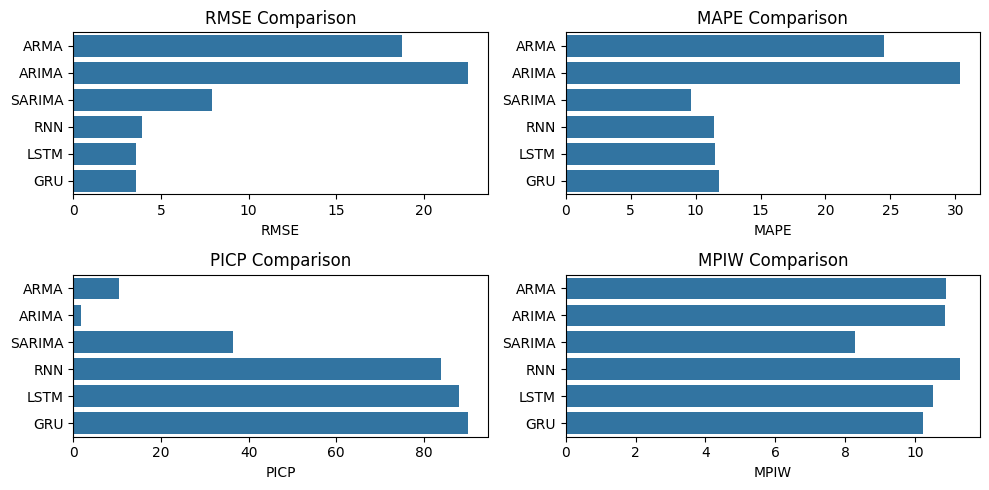

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


data = {
    'Model': ['ARMA','ARIMA', 'SARIMA', 'RNN', 'LSTM', 'GRU'],
    'RMSE': [18.76,22.49, 7.93, 3.92, 3.58, 3.57],
    'MAPE': [24.51,30.39, 9.67, 11.38, 11.49, 11.82],
    'PICP': [10.50,1.66, 36.46, 84.00, 88.00, 90.00],
    'MPIW': [10.88,10.87, 8.28, 11.3, 10.52, 10.24]
}

df = pd.DataFrame(data)

metrics = ['RMSE', 'MAPE', 'PICP', 'MPIW']

plt.figure(figsize=(10, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x=metric, y='Model', data=df)
    plt.title(f'{metric} Comparison')
    plt.xlabel(metric)
    plt.ylabel('')

plt.tight_layout()
plt.show()